In [1]:
!nvidia-smi

Wed Jun  8 22:41:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      On   | 00000000:47:00.0 Off |                   On |
| N/A   38C    P0    88W / 275W |                  N/A |     N/A      Default |
|                               |                      |              Enabled |
+-------------------------------+----------------------+----------------------+

+-----------------------------------------------------------------------------+
| MIG d

In [2]:
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pytorch_model_summary
import numpy as np
import pandas as pd
import random

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split, Dataset, Subset
from datetime import datetime

%matplotlib inline

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
all_data = CIFAR10(root='./data', train=True, transform=transforms.ToTensor(), download=True)

Files already downloaded and verified


In [5]:
len(all_data)

50000

In [6]:
idx2cls = {0:'airplane',
           1:'automobile',
           2:'bird',
           3:'cat',
           4:'deer',
           5:'dog',
           6:'frog',
           7:'horse',
           8:'ship',
           9:'truck'}

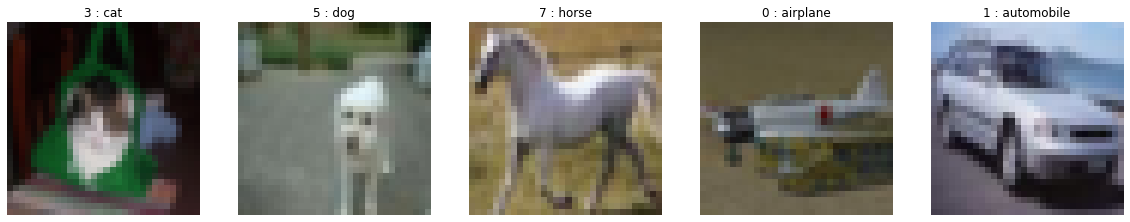

In [7]:
plt.figure(figsize=(20, 10))
for idx in range(5):
    plt.subplot(1, 5, idx+1)
    data = random.choice(all_data)
    img, label = data[0], data[1]
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{label} : {idx2cls[label]}")
    

In [8]:
meanRGB = [np.mean(img.numpy(), axis=(1, 2)) for img,_ in all_data]
stdRGB = [np.std(img.numpy(), axis=(1, 2)) for img,_ in all_data]

meanR = np.mean([m[0] for m in meanRGB])
meanG = np.mean([m[1] for m in meanRGB])
meanB = np.mean([m[2] for m in meanRGB])

stdR = np.mean([s[0] for s in stdRGB])
stdG = np.mean([s[1] for s in stdRGB])
stdB = np.mean([s[2] for s in stdRGB])

print(f"Mean - R:{meanR:.6f}, G:{meanG:.6f}, B:{meanB:.6f}")
print(f"Std  - R:{stdR:.6f}, G:{stdG:.6f}, B:{stdB:.6f}")

Mean - R:0.491400, G:0.482158, B:0.446531
Std  - R:0.202202, G:0.199315, B:0.200863


In [9]:
class CustomSubset(Dataset):
    def __init__(self, dataset, transform=None):
        super(CustomSubset, self).__init__()
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        if self.transform is not None:
            img = self.transform(img)
        return img, label

In [10]:
transform = {
    'train' : transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomResizedCrop((227,227)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(meanR, meanG, meanB), std=(stdR, stdG, stdB))
    ]),
    'test' : transforms.Compose([
        transforms.Resize((256,256)),
        transforms.CenterCrop((227,227)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(meanR, meanG, meanB), std=(stdR, stdG, stdB))
    ])
}

In [11]:
train_ratio = 0.8
train_data_len = int(len(all_data) * train_ratio)
valid_data_len = len(all_data) - train_data_len

print(f"Train_Data_length: {train_data_len}")
print(f"Valid_Data_length: {valid_data_len}")

train_data, valid_data = random_split(all_data, [train_data_len, valid_data_len])

Train_Data_length: 40000
Valid_Data_length: 10000


In [12]:
visual_data_origin = Subset(valid_data, [0, 1, 2, 3, 4])
len(visual_data_origin)

5

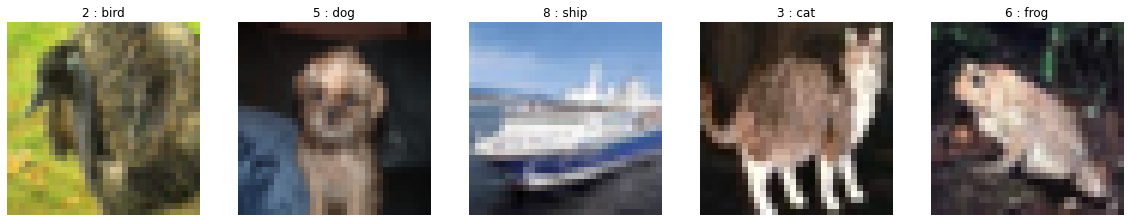

In [13]:
plt.figure(figsize=(20, 10))
for idx in range(5):
    plt.subplot(1, 5, idx+1)
    img = np.transpose(train_data[idx][0], (1, 2, 0))
    label = train_data[idx][1]
    plt.title(f"{label} : {idx2cls[label]}")
    plt.axis("off")
    plt.imshow(img)

In [14]:
all_data.transform = None
train_data = CustomSubset(train_data, transform=transform['train'])
valid_data = CustomSubset(valid_data, transform=transform['test'])
visual_data_trans = CustomSubset(visual_data_origin, transform=transform['test'])
test_data = CIFAR10(root='./data', train=False, transform=transform['test'], download=True)

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


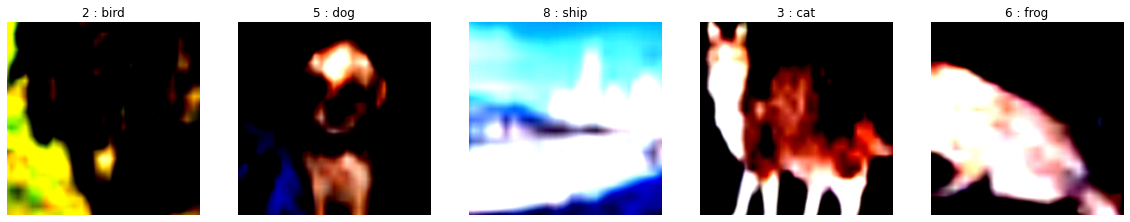

In [15]:
plt.figure(figsize=(20, 10))
for idx in range(5):
    plt.subplot(1, 5, idx+1)
    img = np.transpose(train_data[idx][0], (1, 2, 0))
    label = train_data[idx][1]
    plt.title(f"{label} : {idx2cls[label]}")
    plt.axis("off")
    plt.imshow(img)

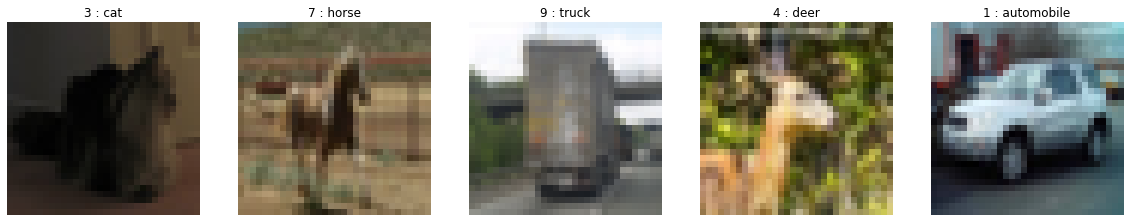

In [16]:
plt.figure(figsize=(20, 10))
for idx in range(5):
    plt.subplot(1, 5, idx+1)
    img = visual_data_origin[idx][0]
    label = visual_data_origin[idx][1]
    plt.title(f"{label} : {idx2cls[label]}")
    plt.axis("off")
    plt.imshow(img)

In [17]:
class MyZFNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(MyZFNet, self).__init__()
        self.convnet = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=7, stride=2, padding=0),
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2.0),
            nn.MaxPool2d(kernel_size=3, stride=2, return_indices=True),
            # UnMaxPool을 위해 return_indices=True

            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2.0),
            nn.MaxPool2d(kernel_size=3, stride=2, return_indices=True),
            
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, return_indices=True)
        )
        self.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=6*6*256, out_features=4096),
            nn.ReLU(),

            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),

            nn.Linear(in_features=4096, out_features=num_classes)
        )

        self.feature_maps = dict()
        self.indices = dict()
        self.init_weights_and_bias()

    # AlexNet과 동일한 weight, bais 초기화.
    def init_weights_and_bias(self):
        conv_idx = 1
        fc_idx = 1
        for layer in self.modules():
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean=0, std=0.01)
                if conv_idx == 1 or conv_idx == 3:
                    nn.init.constant_(layer.bias, 0)
                else:
                    nn.init.constant_(layer.bias, 0.1)
                conv_idx += 1
            elif isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, mean=0, std=0.01)
                if fc_idx <= 2:
                    nn.init.constant_(layer.bias, 0.1)
                else:
                    nn.init.constant_(layer.bias, 0)
                fc_idx += 1


    def forward(self, x):
        self.feature_maps = dict()
        self.indices = dict()
        for idx, layer in enumerate(self.convnet):
            if isinstance(layer, nn.MaxPool2d):
                x, indices = layer(x)
                self.indices[idx] = indices
            else:
                x = layer(x)
            self.feature_maps[idx] = x
        x = torch.flatten(x, 1)
        return self.fc(x)


In [18]:
net = MyZFNet(num_classes=10)
print(pytorch_model_summary.summary(net, torch.zeros(1, 3, 225, 225), show_input=True))

-----------------------------------------------------------------------------
          Layer (type)           Input Shape         Param #     Tr. Param #
              Conv2d-1      [1, 3, 225, 225]          14,208          14,208
                ReLU-2     [1, 96, 110, 110]               0               0
   LocalResponseNorm-3     [1, 96, 110, 110]               0               0
           MaxPool2d-4     [1, 96, 110, 110]               0               0
              Conv2d-5       [1, 96, 54, 54]         614,656         614,656
                ReLU-6      [1, 256, 27, 27]               0               0
   LocalResponseNorm-7      [1, 256, 27, 27]               0               0
           MaxPool2d-8      [1, 256, 27, 27]               0               0
              Conv2d-9      [1, 256, 13, 13]         885,120         885,120
               ReLU-10      [1, 384, 13, 13]               0               0
             Conv2d-11      [1, 384, 13, 13]       1,327,488       1,327,48

In [19]:
# GPU Memory 부족으로 batch_size 줄임.
batch_size = 32
# batch_size = 128

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [20]:
model = MyZFNet(num_classes=10)

criterion = nn.CrossEntropyLoss()

momentum = 0.9
init_lr = 0.01

model = model.to(device)
criterion = criterion.to(device)

optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-5, verbose=True)

In [21]:
class D_MyZFNet(nn.Module):
    def __init__(self, net):
        super(D_MyZFNet, self).__init__()
        self.layers = list()
        for i, layer in enumerate(net.convnet):
            if isinstance(layer, nn.Conv2d):
                self.layers.append(nn.ConvTranspose2d(layer.out_channels, layer.in_channels, layer.kernel_size, layer.stride, layer.padding, bias=False))
                self.layers[i].weight.data = layer.weight.data
            elif isinstance(layer, nn.ReLU):
                self.layers.append(nn.ReLU())
            elif isinstance(layer, nn.MaxPool2d):
                self.layers.append(nn.MaxUnpool2d(layer.kernel_size, layer.stride, layer.padding))
            else:
                self.layers.append(None)
    
    def forward(self, x, to_visualize_layer, net):
        if not 0 <= to_visualize_layer < len(self.layers):
            raise IndexError(f'idx_to_visualize must in the range {0} to {len(self.layers) - 1}')
            
        for idx in range(to_visualize_layer, -1, -1):
            if isinstance(self.layers[idx], nn.MaxUnpool2d):
                x = self.layers[idx](x, net.indices[idx], net.feature_maps[idx-1].shape)
            elif self.layers[idx] == None:
                continue
            else:
                x = self.layers[idx](x)
        return x
            

In [22]:
d_model = D_MyZFNet(model).to(device)

In [23]:
def train(model, d_model, epochs, train_loader, valid_loader, visual_data_origin, visual_data_trans, criterion, optimizer, scheduler, print_log=True, early_stop=None, model_path='myzfnet.pth'):
    train_logs = {'Loss' : [], 'Accuracy' : []}
    valid_logs = {'Loss' : [], 'Accuracy' : []}
    patience = 0
    best_acc = -np.inf

    plt.figure(figsize=(20, 15))
    for idx in range(len(visual_data_origin)):
        plt.subplot(len(visual_data_origin), 9, 9*idx+1)
        img = visual_data_origin[idx][0]
        plt.axis("off")
        plt.imshow(img)
    
    for epoch in range(epochs):
        train_loss = 0
        valid_loss = 0
        train_acc = 0
        valid_acc = 0
        
        # train_step
        model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            
            pred = model(data)
            loss = criterion(pred, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * data.size(0)
            train_acc += torch.sum(pred.argmax(1) == target).item()
            
        train_loss /= len(train_data)
        train_acc /= len(train_data)
        train_logs['Loss'].append(train_loss)
        train_logs['Accuracy'].append(train_acc)

        
        if print_log and epoch%10 == 0:
            print(f"Training   Epoch {epoch+1} - Loss: {train_loss:.8f}, Accuracy: {train_acc*100:.4f}%")
        
    
        with torch.no_grad():
            model.eval()
            for data, target in valid_loader:
                data, target = data.to(device), target.to(device)
                pred = model(data)
                loss = criterion(pred, target)
                valid_loss += loss.item() * data.size(0)
                valid_acc += torch.sum(pred.argmax(1) == target).item()
                
            valid_loss /= len(valid_data)
            valid_acc /= len(valid_data)
            valid_logs['Loss'].append(valid_loss)
            valid_logs['Accuracy'].append(valid_acc)
            
            if print_log and epoch%10 == 0:
                print(f"Validation Epoch {epoch+1} - Loss: {valid_loss:.8f}, Accuracy: {valid_acc*100:.4f}%")
    
            
            d_model.eval()
            to_visualize_epochs = [1, 2, 5, 10, 20, 30, 40, 64]
            to_visualize_layer = 11
            if epoch+1 in to_visualize_epochs:
                for idx in range(len(visual_data_trans)):
                    data = visual_data_trans[idx][0].unsqueeze(0).to(device)
                    pred = model(data)
                    
                    feature_maps = model.feature_maps[to_visualize_layer]
                    feature_sort = torch.argsort(torch.sum(feature_maps[0], axis=(-1,-2)), descending=True)
    
                    feature_map = torch.zeros_like(feature_maps)
                    feature_map[0, feature_sort[0]] = feature_maps[0, feature_sort[0]]
            
            
                    plt.subplot(len(visual_data_trans), 9, 9*idx + to_visualize_epochs.index(epoch+1) + 2)
                    img_ = d_model(feature_map, to_visualize_layer, model)
                    img_ = img_.cpu().numpy()[0].transpose(1, 2, 0)
                    img_ = (img_ - img_.min()) / (img_.max() - img_.min()) * 255.
                    img_ = img_.astype(np.uint8)
                    
                    plt.title(f"Epoch: {epoch+1}")
                    plt.axis("off")
                    plt.imshow(img_)

                    
            if valid_acc > best_acc:
                best_acc = valid_acc
                torch.save(model.state_dict(), model_path)
                if early_stop is not None:
                    patience = 0
            elif early_stop is not None:
                patience += 1
                if patience == early_stop:
                    print('Training finished by early stopping')
                    plt.savefig('FeaturemapsPerEpoch.jpg')
                    plt.show()
                    return train_logs, valid_logs
            
            # lr scheduler
            scheduler.step(valid_loss)

    return train_logs, valid_logs


In [24]:
start_time = datetime.now()
print(start_time)

2022-06-08 22:42:16.421559


Training   Epoch 1 - Loss: 2.14147849, Accuracy: 18.2400%
Training   Epoch 11 - Loss: 1.16012433, Accuracy: 59.0050%
Validation Epoch 11 - Loss: 0.81077043, Accuracy: 71.7600%
Training   Epoch 21 - Loss: 0.97602898, Accuracy: 65.8575%
Validation Epoch 21 - Loss: 0.60937790, Accuracy: 79.3400%
Training   Epoch 31 - Loss: 0.90988780, Accuracy: 68.8350%
Validation Epoch 31 - Loss: 0.58149520, Accuracy: 80.8600%
Training   Epoch 41 - Loss: 0.88092011, Accuracy: 69.5725%
Validation Epoch 41 - Loss: 0.52029602, Accuracy: 82.5500%
Training   Epoch 51 - Loss: 0.89153942, Accuracy: 69.6600%
Validation Epoch 51 - Loss: 0.54402219, Accuracy: 82.0600%
Epoch    52: reducing learning rate of group 0 to 1.0000e-03.
Training   Epoch 61 - Loss: 0.63665105, Accuracy: 78.0575%
Validation Epoch 61 - Loss: 0.37542121, Accuracy: 87.4300%


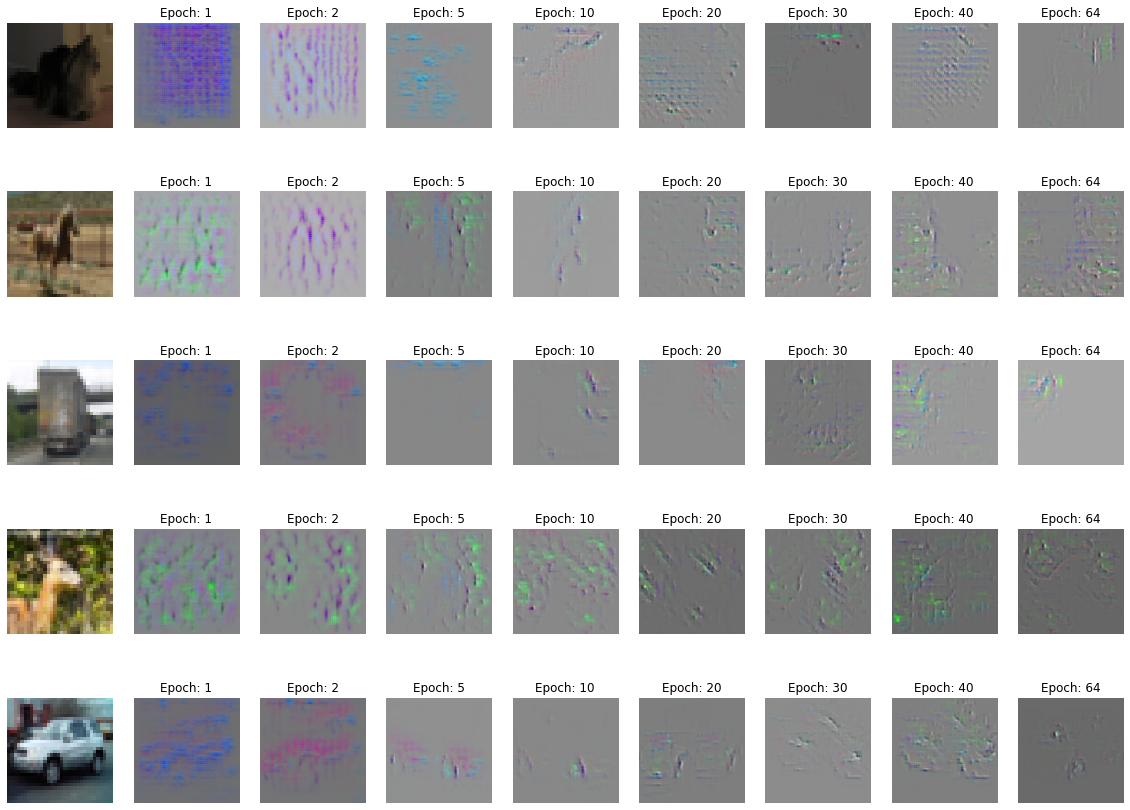

In [25]:
epochs = 70

train_logs, valid_logs = train(model=model,
                              d_model=d_model,
                              epochs=epochs,
                              train_loader=train_loader,
                              valid_loader=valid_loader,
                              visual_data_origin=visual_data_origin,
                              visual_data_trans=visual_data_trans,
                              criterion=criterion,
                              optimizer=optimizer,
                              scheduler=scheduler,
                              early_stop=10)

In [26]:
end_time = datetime.now()
print(end_time)

2022-06-09 05:25:10.626693


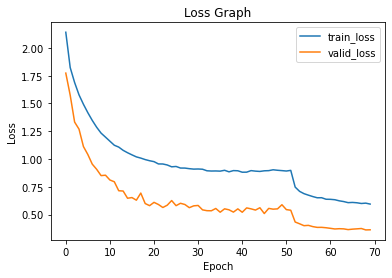

In [27]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot([i for i in range(len(train_logs['Loss']))], train_logs['Loss'], label='train_loss')
plt.plot([i for i in range(len(valid_logs['Loss']))], valid_logs['Loss'], label='valid_loss')
plt.legend()
plt.title("Loss Graph")
plt.show()

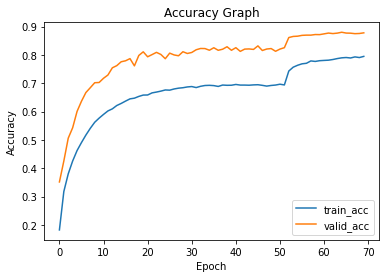

In [28]:
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot([i for i in range(len(train_logs['Accuracy']))], train_logs['Accuracy'], label='train_acc')
plt.plot([i for i in range(len(valid_logs['Accuracy']))], valid_logs['Accuracy'], label='valid_acc')
plt.legend()
plt.title("Accuracy Graph")
plt.show()

In [29]:
model.load_state_dict(torch.load('myzfnet.pth'))
model = model.to(device)

In [30]:
def test(model, criterion, test_loader):
    test_loss = 0
    test_acc = 0
    with torch.no_grad():
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            pred = model(data)
            loss = criterion(pred, target)
            test_loss += loss.item() * data.size(0)
            test_acc += torch.sum(pred.argmax(1) == target).item()
        test_loss /= len(test_data)
        test_acc /= len(test_data)
    return test_loss, test_acc

In [31]:
test_loss, test_acc = test(model=model,
                           criterion=criterion,
                           test_loader=test_loader)

In [32]:
print(f"Test - Loss: {test_loss:.8f}, Accuracy: {test_acc*100:.6f}%")

Test - Loss: 0.38336635, Accuracy: 87.610000%


In [33]:
unNormalizeTransform = transforms.Compose([
    transforms.Normalize(mean=[-meanR/stdR, -meanG/stdG, -meanB/stdB],
                         std=[1.0/stdR, 1.0/stdG, 1.0/stdB]),
    transforms.ToPILImage()
])

In [34]:
def visualize_each_layer(model, d_model, data, unNormalizeTransform):
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 6, 1)
    img = unNormalizeTransform(data)
    plt.axis('off')
    plt.imshow(img)


    data = data.unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        pred = model(data)

    conv_layers = []
    for idx, layer in enumerate(model.convnet):
        if isinstance(layer, nn.Conv2d):

            conv_layers.append(idx)



    for idx, conv_idx in enumerate(conv_layers):
        plt.subplot(1, 6, idx+2)

        feature_maps = model.feature_maps[conv_idx]
        feature_sort = torch.argsort(torch.sum(feature_maps[0], axis=(-1, -2)), descending=True)
        feature_map = torch.zeros_like(feature_maps)
        feature_map[0, feature_sort[0]] = feature_maps[0, feature_sort[0]]
        feature_map = feature_map.to(device)
        
        d_model.eval()
        with torch.no_grad():
            img_ = d_model(feature_map, conv_idx, model)
        img_ = img_.cpu().numpy()[0].transpose(1, 2, 0)
        img_ = (img_ - img_.min()) / (img_.max() - img_.min()) * 255.
        img_ = img_.astype(np.uint8)

        plt.title(f"Conv Layer: {idx+1}")
        plt.axis('off')
        plt.imshow(img_)

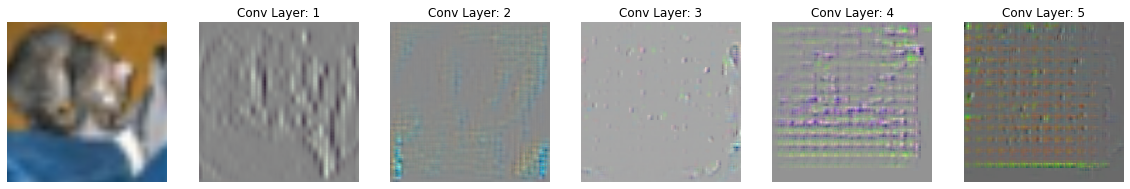

In [35]:
visualize_each_layer(model, d_model, test_data[0][0], unNormalizeTransform)